<a href="https://colab.research.google.com/github/virf96/Chat-Bot/blob/master/DatosFaltantes_SustitucionFinalDistribucion_FeatureEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sustitución por valores al final de la distribución  ==> Feature-engine


### Qué es Feature-engine?

Feature-engine es una librería de Python que hemos creado para este curso. 

- Feature-engine incluye todas las técnicas de ingeniería de variables descritas en este curso
- Feature-engine funciona como Scikit-learn, por lo tanto es fácil de aprender
- Feature-engine te permite implementar pasos de ingeniería de variables específicos para diferentes grupos de variables
- Feature-engine puede ser integrado con las pipelines de Scikit-learn pipeline permitiendo construir modelos fácilmente
** Feature-engine te permite diseñar y guardar un flujo de ingeniería de variables con procesos diseñados específicamente para diferentes grupos de variables.**

-------------------------------------------------------------------
Feature-engine puede ser instalado vía pip ==> pip install feature-engine

- Asegurate que haz instalado Feature-engine antes de correr este notebook

Para más detalle visita el [website the trainindata]( https://www.trainindata.com/feature-engine) 


## En este demo:

Vamos a usar **Feature-engine para hacer la sustitución por valores al final de la distribución** usando los datos Ames House Price.

### Nota: 
* 'Imputer' se deriva del verbo en inglés 'to impute' que quiere decir sustituir o reemplazar. Imputer es el objeto que completa la sustitución, de ahí el nombre dado a la clase.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install feature_engine

     |████████████████████████████████| 9.5MB 5.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# feature engine
from feature_engine import missing_data_imputers as mdi

In [6]:
# carguemos los datos con unas columnas seleccionadas

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('/content/drive/My Drive/datasets/houseprice.csv', usecols=cols_to_use)
data.head()

,LotFrontage,MasVnrArea,BsmtQual,FireplaceQu,GarageYrBlt,SalePrice
0,65.0,196.0,Gd,NaN,2003.0,208500
1,80.0,0.0,Gd,TA,1976.0,181500
2,68.0,162.0,Gd,TA,2001.0,223500
3,60.0,0.0,TA,Gd,1998.0,140000
4,84.0,350.0,Gd,TA,2000.0,250000


In [9]:
#Veamos porcentaje de nulos
data.isnull().mean().sort_values(ascending=False)

FireplaceQu    0.472603
LotFrontage    0.177397
GarageYrBlt    0.055479
BsmtQual       0.025342
MasVnrArea     0.005479
SalePrice      0.000000
dtype: float64

Todas las variables predictivas tienen datos ausentes

In [10]:
# separar datos en segmentos entrenamiento y prueba

# primero, separemos el target (SalePrice) del resto de las variables

#Separamos el set en train y test porque la función debe trabajar con el set de entramiento solamente
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 5), (438, 5))

### Feature-engine captura las variables numéricas automáticamente

In [11]:
# llamemos el imputer de Feature-engine
# especifiquemos si queremos encontrar los valores usando una
# aproximación de una distribución gaussiana o la regla de 
# proximidad del rango inter-cuantil

# adicionalmente tenemos que especificar si queremos los valores al principio o al final
# de la distribución

imputer = mdi.EndTailImputer(distribution='gaussian', tail='right')

In [12]:
# ajustamos el imputer al set de entrenamiento

imputer.fit(X_train)

EndTailImputer(distribution='gaussian', fold=3, tail='right',
               variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])

In [13]:
# vemos que el imputer encontró las variables numéricas 
# para sustituir con valores al final de la distribución

imputer.variables

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [14]:
# aquí podemos ver los valores que serán usados para reemplazar los
# valores nulos NA para cada variable

imputer.imputer_dict_

{'GarageYrBlt': 2052.9707419772235,
 'LotFrontage': 138.9022201686726,
 'MasVnrArea': 648.3947111415157}

In [15]:
# y así es como estas parámetros fueron calculados
# que es precisamente la forma que aprendimos en los 
# primeros notebooks de esta sección

X_train[imputer.variables].mean() + 3 * X_train[imputer.variables].std()

LotFrontage     138.902220
MasVnrArea      648.394711
GarageYrBlt    2052.970742
dtype: float64

In [16]:
# feature engine retorna un dataframe

tmp = imputer.transform(X_train)
tmp.head()

,BsmtQual,FireplaceQu,LotFrontage,MasVnrArea,GarageYrBlt
64,Gd,NaN,138.90222,573.0,1998.000000
682,Gd,Gd,138.90222,0.0,1996.000000
960,TA,NaN,50.00000,0.0,2052.970742
1384,TA,NaN,60.00000,0.0,1939.000000
1100,TA,NaN,60.00000,0.0,1930.000000


In [17]:
# revisemos que las variables numéricas ya no tienen NA

tmp[imputer.variables].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
dtype: float64

## Feature-engine te permite especificar grupos de variables fácilmente

In [18]:
# usemos la sustitución pero esta vez solo 
# imputemos 2 de la 3 variables numéricas

# seleccionemos la regla de la proximidad entre-cuantil 
# y a la izquierda de la distribución

imputer = mdi.EndTailImputer(distribution='skewed', tail='left',
                             variables=['LotFrontage', 'MasVnrArea'])

imputer.fit(X_train)

EndTailImputer(distribution='skewed', fold=3, tail='left',
               variables=['LotFrontage', 'MasVnrArea'])

In [19]:
# ahora el imputer solo imputa variable que le indicamos
imputer.variables

['LotFrontage', 'MasVnrArea']

In [20]:
# y podemos ver el valor asignado para cada variable

imputer.imputer_dict_

{'LotFrontage': -8.0, 'MasVnrArea': -510.0}

In [21]:
# feature engine devuelve un dataframe

tmp = imputer.transform(X_train)

# revisemos que los valores nulos ya no existen
tmp[imputer.variables].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

## Feature-engine puede ser usado con los flujos de Scikit-learn (pipeline)

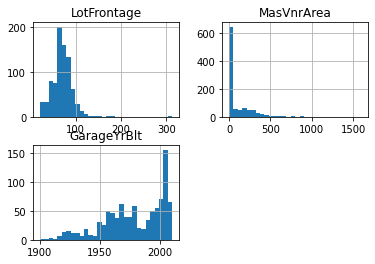

In [22]:
# miremos las distribuciones y determinemos el valor para el método de sustitución al 
#final de la distribución

X_train.hist(bins=30)
plt.show()

Todas las variables están sesgadas. 

En este demo, usaremos la regla de la proximidad entre-cuantil para GarageYrBlt y MasVnrArea, y la aproximación gaussiana para LotFrontage.

In [23]:
pipe = Pipeline([
    ('imputer_skewed', mdi.EndTailImputer(distribution='skewed', tail='right',
                                          variables=['GarageYrBlt', 'MasVnrArea'])),

    ('imputer_gaussian', mdi.EndTailImputer(distribution='gaussian', tail='right',
                                            variables=['LotFrontage'])),
])

In [24]:
pipe.fit(X_train)

Pipeline(memory=None,
         steps=[('imputer_skewed',
                 EndTailImputer(distribution='skewed', fold=3, tail='right',
                                variables=['GarageYrBlt', 'MasVnrArea'])),
                ('imputer_gaussian',
                 EndTailImputer(distribution='gaussian', fold=3, tail='right',
                                variables=['LotFrontage']))],
         verbose=False)

In [25]:
pipe.named_steps['imputer_skewed'].imputer_dict_

{'GarageYrBlt': 2121.0, 'MasVnrArea': 680.0}

In [26]:
pipe.named_steps['imputer_gaussian'].imputer_dict_

{'LotFrontage': 138.9022201686726}

In [27]:
# transformemos los datos con la pipeline
tmp = pipe.transform(X_train)

# revisemos que ya no tenemos valores nulos
tmp.isnull().mean()

BsmtQual       0.023483
FireplaceQu    0.467710
LotFrontage    0.000000
MasVnrArea     0.000000
GarageYrBlt    0.000000
dtype: float64

Ya no tenemos valores nulos para ninguna de las 3 variables numéricas que sustituimos.

More details here:
https://feature-engine.readthedocs.io/en/latest/imputers/EndTailImputer.html